# System identification 7m with 7m VCT prior

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
ships

['M5064-02-A', 'wPCC', '7m']

In [5]:
%reload_kedro
ship='7m'
prior_ship = 'wPCC'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/08/23 10:39:38] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=208770;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=30962;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/08/23 10:39:38] INFO     Kedro project phd                                                      ]8;id=518985;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=953979;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=426921;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=56534;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=899997;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=445110;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=833991;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=861091;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=882159;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=791953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.time_series_meta_data' (CSVDataSet)...       ]8;id=823739;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=74619;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data_prior_ship = catalog.load(f"{prior_ship}.ship_data")

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=133749;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=535712;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
scaling = ship_data_prior_ship['scale_factor']/ship_data['scale_factor']
ship_data['I_z'] = ship_data_prior_ship['I_z']*scaling**5
ship_data['x_G'] = -9.8/ship_data_prior_ship['scale_factor']

In [8]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1000,
 'm': 1155,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'I_z': 3386.0314842592607,
 'x_G': -0.23786407766990292}

In [9]:
np.sqrt(ship_data['I_z']/ship_data['m'])/ship_data['L']

0.24460000628684303

In [10]:
72.1/206.6

0.3489835430784124

In [11]:
time_series_meta_data['tws'] = (time_series_meta_data['twsBow'] + time_series_meta_data['twsStern'])/2

<Axes: xlabel='date'>

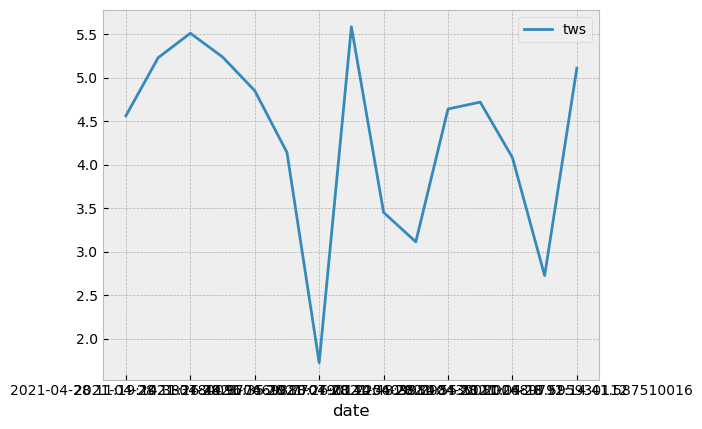

In [12]:
time_series_meta_data.plot(x='date', y='tws')

In [13]:
time_series_meta_data['delta_abs'] = time_series_meta_data['delta'].abs()
time_series_meta_data.sort_values(by='date', ascending=True)

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0,date,tws,delta_abs
motorZZ_1_thruster_100_Port,4.614160,4.525495,2.486891,12.286663,12.305938,59.292991,18.324195,0.055550,0.697962,3.107473,3.132236,1.710958,0.706300,2.914798,3.133645,1.730714,0.214779,2.486891,0.302276,2.454673,0.661543,4.614160,0.055550,44.475843,315.785062,316.548351,47.173993,2021-04-28 10:26:01.225609984,1.720836,0.214779
motorZZ_2_thruster_100_Stb,3.556798,3.646648,2.388526,12.592144,12.538125,59.284942,18.323452,0.061287,0.801782,7.926677,1.237516,5.693845,0.784665,7.708125,1.201041,5.481916,0.218832,2.388526,0.356135,2.388515,0.714152,3.556798,0.061287,22.452942,321.098569,322.718239,24.741893,2021-04-28 10:40:18.614870016,5.587881,0.218832
motorZZ_3_thruster_80_Port,6.280696,6.282109,2.262368,12.716622,12.770312,59.287654,18.324165,0.099516,3.119444,2.417766,3.138106,3.484717,3.139754,2.130466,3.140242,3.418727,0.222884,2.262368,7.497672,2.250966,1.980268,6.691098,0.099516,39.969739,314.868037,317.613195,40.023059,2021-04-28 10:48:38.208430080,3.451722,0.222884
motorZZ_4_thruster_80_Stb,6.282978,6.278361,2.210224,20.308812,11.145000,59.291236,18.323485,0.058311,3.032030,2.233553,3.141137,3.112513,3.068972,2.232856,3.135590,3.112824,0.194517,2.210224,1.649388,2.207696,2.058192,6.409949,0.058311,75.484327,295.891992,296.675612,78.176643,2021-04-28 10:52:06.805670144,3.112668,0.194517
motorZZ_5_thruster_60_Stb,6.282165,6.273283,1.795074,13.440897,13.466875,59.294757,18.321576,0.040460,3.136648,3.013644,3.140824,4.461304,3.140425,3.485960,3.138969,4.821664,0.235041,1.795074,1.515657,1.790822,1.717576,6.425945,0.040460,44.931843,272.685966,274.917855,46.629282,2021-04-28 10:55:51.202689792,4.641484,0.235041
motorZZ_6_thruster_60_Port,6.281565,6.275344,1.839285,13.035028,13.002500,59.297606,18.320594,0.052482,3.136805,2.901553,3.140962,4.327306,3.135835,3.393899,3.137505,5.114666,0.226936,1.839285,1.597817,1.833096,1.720829,6.758666,0.052482,30.638473,272.248203,274.928639,30.777402,2021-04-28 10:59:02.200130048,4.720986,0.226936
motorZZ_7_thruster_40_Stb,6.282389,6.279349,1.308986,11.263334,11.145000,59.301677,18.319883,0.050605,3.138552,2.697535,3.139877,3.926706,3.138554,2.955966,3.137279,4.237384,0.194517,1.308986,2.032278,1.302223,1.229920,6.345685,0.050605,25.140704,214.983667,217.122696,26.953763,2021-04-28 11:04:18.595930112,4.082045,0.194517
motorZZ_8_thruster_40_Port,6.282058,6.280033,1.270748,11.638632,11.609375,59.303793,18.319322,0.038099,3.136076,2.205084,3.137502,2.774606,3.128708,2.022677,3.137482,2.672486,0.202622,1.270748,6.333943,1.249226,1.199217,6.398557,0.038099,15.366148,209.195752,211.984522,15.645311,2021-04-28 11:07:42.593159936,2.723546,0.202622
motorZZ_9_thruster_40,3.407302,3.616633,1.059056,11.905680,11.841563,59.302297,18.319604,0.069269,0.651276,6.338551,0.903630,5.421382,0.683296,5.699430,0.946288,4.802026,0.206674,1.059056,0.457297,1.059056,0.424083,3.407302,0.069269,5.476522,189.752303,191.995207,4.885254,2021-04-28 11:14:41.587510016,5.111704,0.206674
motorZZ_10_thruster_40,3.814295,3.925403,1.086174,10.027171,9.984063,59.300022,18.319696,0.127323,0.670234,5.673418,0.889456,4.854953,0.734507,5.074579,0.988236,4.272943,0.174255,1.086174,0.587098,1.083376,0.588585,3.814295,0.127323,8.745948,180.474807,182.941952,10.078548,2021-04-28 11:19:14.383780096,4.563948,0.174255


In [14]:
id = "motorZZ_2_thruster_100_Stb"
data_raw = time_series[str(id)]()
data_raw.drop(columns=['date'], inplace=True)

In [15]:
data_raw.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0
time(s),,,,,,,,,,,,,,,,,,,,,,,,,,,
0.00000,3.120886,3.106032,2.128076,2.804897,3.018437,59.284942,18.323022,0.032027,-0.618869,5.579988,-0.939304,4.133509,-0.659069,4.945075,-1.045442,3.602604,-0.052682,2.128076,0.014854,2.127841,-0.031609,3.120886,0.032027,0.000000,0.000000,-2.749159,0.552040
0.20001,3.122273,3.097148,2.122014,2.584824,2.865014,59.284938,18.323022,0.027691,-0.616928,5.582082,-0.933836,4.122666,-0.656724,4.940662,-1.040329,3.584795,-0.050004,2.122014,0.025125,2.121344,-0.053309,3.122273,0.027691,0.011402,-0.452316,-3.202238,0.559629
0.39999,3.126400,3.100304,2.146155,2.353527,2.554062,59.284934,18.323023,0.019367,-0.615155,5.587342,-0.927547,4.115124,-0.653445,4.939987,-1.032666,3.568720,-0.044577,2.146155,0.026096,2.145424,-0.055999,3.126400,0.019367,0.022960,-0.888321,-3.640482,0.559833
0.59998,3.130993,3.121191,2.132209,2.151748,2.321875,59.284930,18.323023,0.013995,-0.612801,5.592782,-0.921919,4.108716,-0.650208,4.935740,-1.026915,3.551416,-0.040524,2.132209,0.009802,2.132106,-0.020900,3.130993,0.013995,0.027334,-1.310438,-4.065036,0.551561
0.79996,3.133984,3.147556,2.155146,2.056626,2.089688,59.284926,18.323023,0.015883,-0.609977,5.597850,-0.917656,4.103262,-0.647193,4.927286,-1.023938,3.532870,-0.036472,2.155146,-0.013572,2.154947,0.029248,3.133984,0.015883,0.021092,-1.737605,-4.493758,0.537078


In [16]:
data = load(raw_data=data_raw)

delta = data['delta'] = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
#delta = data['delta']
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
#data = add_thrust(data, thrust_channels=thrust_keys)

<Axes: xlabel='time(s)'>

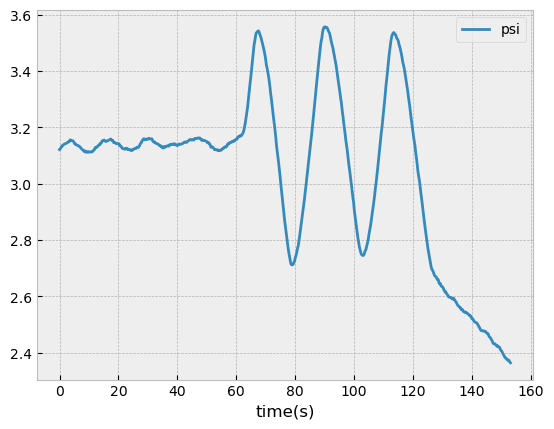

In [17]:
data_all.plot(y='psi')

<Axes: xlabel='time(s)'>

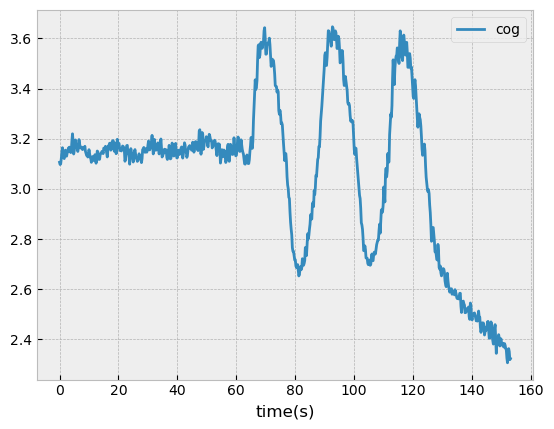

In [18]:
data.plot(y='cog')

<Axes: xlabel='time(s)'>

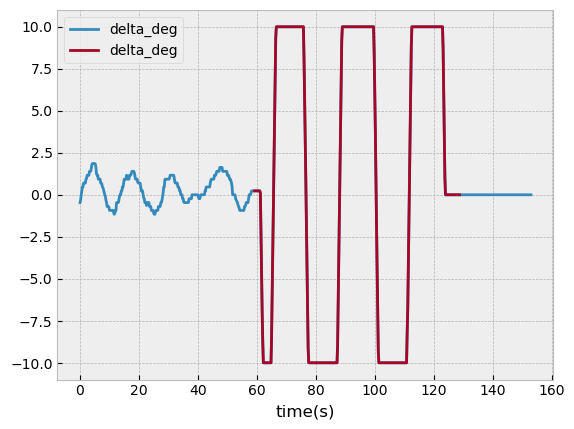

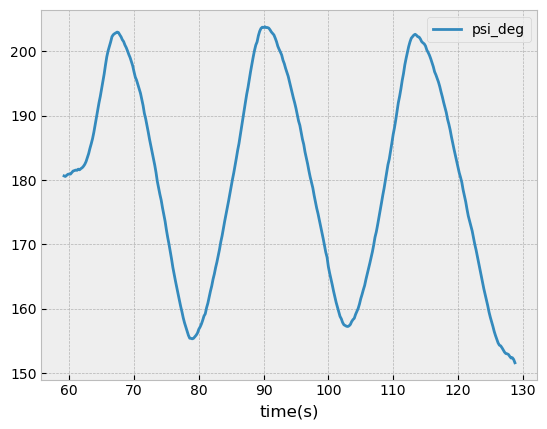

In [19]:
tolerance = 0.01
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = delta.abs() >= (1-tolerance)*delta.abs().max()
start = data.loc[mask].index[0]
end = data.loc[mask].index[-1]
data = data.iloc[data.index.get_loc(start)-15:data.index.get_loc(end)+30].copy()
#data = data.iloc[data.index.get_loc(start)+50:data.index.get_loc(end)+30].copy()


fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
data.plot(y='delta_deg', ax=ax)
fig,ax=plt.subplots()
data.plot(y='psi_deg', ax=ax)

<Axes: xlabel='time(s)'>

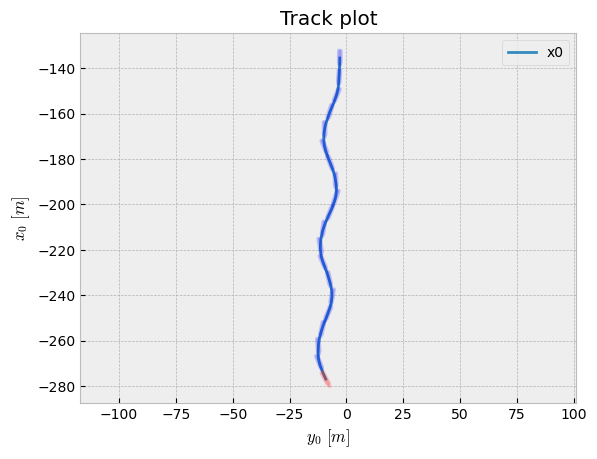

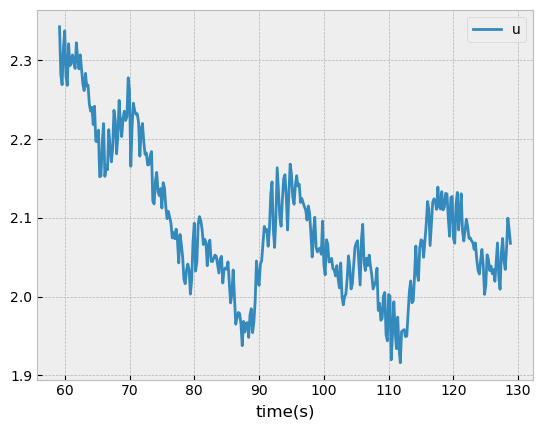

In [20]:
track_plot(df=data, lpp=ship_data['L'], beam=ship_data['B']);
data.plot(y='u')

In [21]:
model_VCT = Simulator.load("model_7m_abkowitz_simplified_VCT.pkl")
model_VCT.parameters['Xu'] = 0
#model_VCT.parameters['Xvr'] = 0
model_VCT.parameters['Xdeltadelta'] = 0
#model_VCT.parameters['Ydelta']*=1.5
#model_VCT.parameters['Ndelta']*=1.5

In [22]:
model_VCT.parameters

Xudot          0.000000
Xdeltadelta    0.000000
Xu             0.000000
Xvr           -0.003068
Yrdot         -0.000303
Yvdot         -0.006109
Ydelta         0.006421
Yr             0.003643
Yvvv          -0.175645
Yv            -0.007141
Yvr            0.013694
Nrdot         -0.000299
Nvdot         -0.000128
Ndelta        -0.003099
Nrrr          -0.000281
Nr            -0.002808
Nvvv           0.008593
Nv            -0.001048
dtype: float64

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [23]:
vmm = VMM(X_eq=model_VCT.X_eq, Y_eq = model_VCT.Y_eq, N_eq = model_VCT.N_eq)

In [24]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [25]:
system_matrixes._lambda_f

<function _lambdifygenerated(Yvdot, m, Xvr, Nvvv, Nvdot, Ndelta, v, psi, delta, Yrdot, Xudot, Yv, r, Yvr, Xdeltadelta, I_z, Nrdot, Nrrr, Yvvv, Nv, Xu, rho, u, Ydelta, Yr, Nr, L, x_G)>

In [26]:
system_matrixes._lambda_jacobian

<function _lambdifygenerated(Yvdot, m, Xvr, Nvvv, Nvdot, Ndelta, v, psi, delta, Yrdot, Xudot, Yv, r, Yvr, Xdeltadelta, I_z, Nrdot, Nrrr, Yvvv, Nv, Xu, rho, u, Ydelta, Yr, Nr, L, x_G, h)>

In [27]:
model_VCT.parameters

Xudot          0.000000
Xdeltadelta    0.000000
Xu             0.000000
Xvr           -0.003068
Yrdot         -0.000303
Yvdot         -0.006109
Ydelta         0.006421
Yr             0.003643
Yvvv          -0.175645
Yv            -0.007141
Yvr            0.013694
Nrdot         -0.000299
Nvdot         -0.000128
Ndelta        -0.003099
Nrrr          -0.000281
Nr            -0.002808
Nvvv           0.008593
Nv            -0.001048
dtype: float64

## model VCT initial guessed parameters

In [28]:
#parameters = {key:value for key,value in model_VCT.parameters.items() if not 'dot' in key}
parameters = model_VCT.parameters.to_dict()

In [29]:
parameters

{'Xudot': 0.0,
 'Xdeltadelta': 0.0,
 'Xu': 0.0,
 'Xvr': -0.0030677925327719886,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Ydelta': 0.006421255815780696,
 'Yr': 0.0036429893421288666,
 'Yvvv': -0.1756449904336061,
 'Yv': -0.00714112872778315,
 'Yvr': 0.01369396189020632,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Ndelta': -0.0030994931341465854,
 'Nrrr': -0.0002812547715010821,
 'Nr': -0.002808414520962192,
 'Nvvv': 0.008593283714686095,
 'Nv': -0.00104759589337324}

In [30]:
parameters['Nrdot']

-0.00029867482773178765

## Extended Kalman Filter

In [31]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [32]:
ek.parameters

Xvr           -0.003068
Nrdot         -0.000299
Yvdot         -0.006109
Xdeltadelta    0.000000
Yvvv          -0.175645
Xudot          0.000000
Nr            -0.002808
Nvdot         -0.000128
Nrrr          -0.000281
Nvvv           0.008593
Nv            -0.001048
Ydelta         0.006421
Yv            -0.007141
Ndelta        -0.003099
Yrdot         -0.000303
Yvr            0.013694
Xu             0.000000
Yr             0.003643
dtype: float64

In [33]:
ek.get_all_coefficients(sympy_symbols=False)

['Xvr',
 'Nrdot',
 'Yvdot',
 'Xdeltadelta',
 'Yvvv',
 'Xudot',
 'Nr',
 'Nvdot',
 'Nrrr',
 'Nvvv',
 'Nv',
 'Ydelta',
 'Yv',
 'Ndelta',
 'Yrdot',
 'Yvr',
 'Xu',
 'Yr']

In [34]:
x0 = initial_state(data)

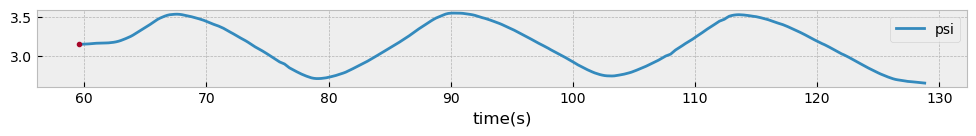

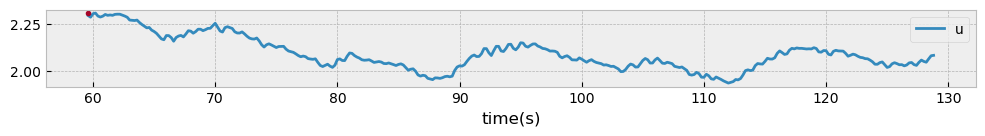

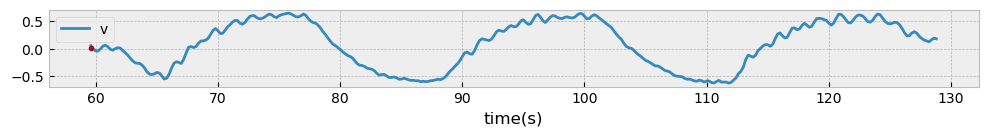

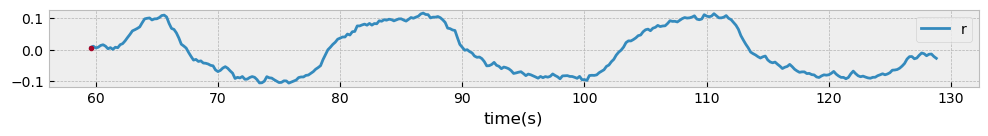

In [35]:
keys = ['psi','u','v','r']
for key in keys:
    fig,ax=plt.subplots()
    fig.set_size_inches(12,1)
    df_ = data.rolling(window=3).mean().dropna()
    df_.plot(y=key, ax=ax)
    ax.plot(df_.index[0],x0[key],'.')
    

In [36]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.3
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)     

 
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes['P_prd'][3][3]/=1000

In [37]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 6.052096512000002e-07, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.06052096512000001, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 6.68983734958142e-05]],
 'Qd': [[0.0006052096512000002, 0.0, 0.0],
  [0.0, 0.06052096512000001, 0.0],
  [0.0, 0.0, 6.68983734958142e-05]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

In [38]:
covariance_matrixes['P_prd']

[[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 6.052096512000002e-07, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.06052096512000001, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 6.68983734958142e-05]]

## Filter states with initially guessed model

In [39]:
x0

{'x0': -136.48748263461167,
 'y0': -2.9132183891907033,
 'psi': 3.154737854003908,
 'u': 2.3092244645646245,
 'v': 0.009047493755701104,
 'r': 0.0049059984729820285}

In [40]:
data_ = data.copy()
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=parameters)

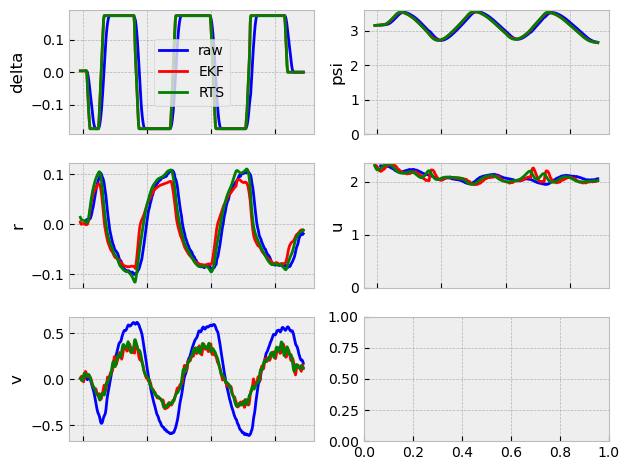

In [41]:
data_ = data.copy()

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
}
plot(dataframes=dataframes, keys=['u','v','r','psi','delta']);


<Axes: xlabel='time(s)'>

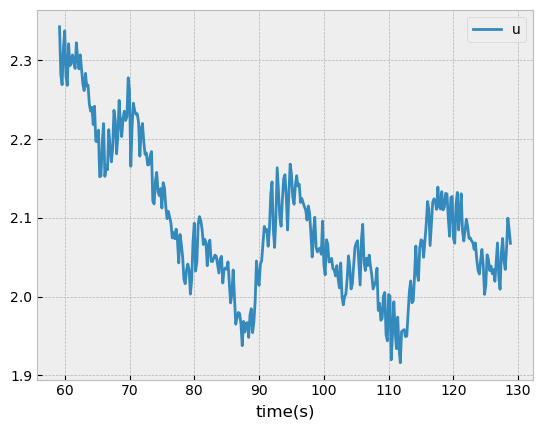

In [42]:
data.plot(y='u')

## Inverse dynamics regression

In [43]:
added_masses = extract_added_masses(parameters=parameters)

In [44]:
#data_with_force = predict_force(data=data.rolling(window=2).mean().dropna(), added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

<Axes: xlabel='delta'>

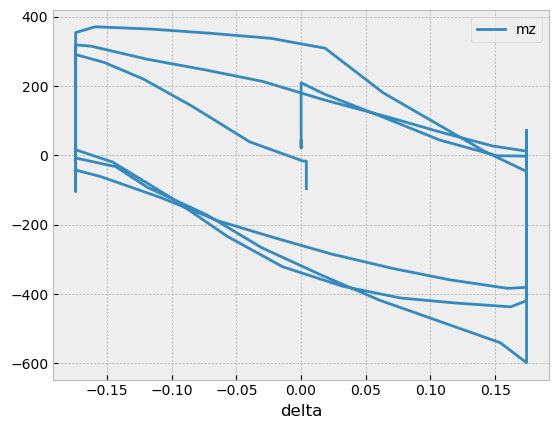

In [45]:
data_with_force.plot(x='delta', y='mz')

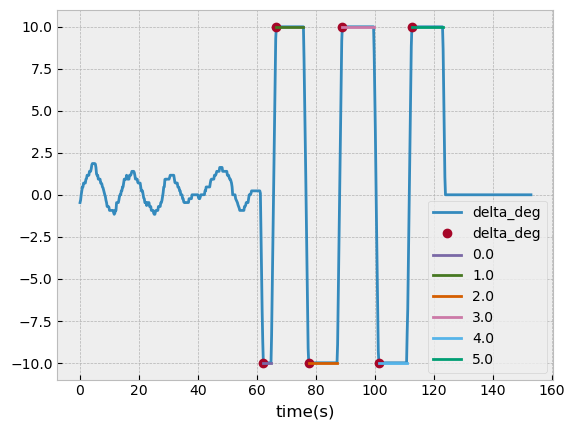

In [46]:
tolerance = 0.001
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = data_all['delta'].abs() >= (1-tolerance)*data_all['delta'].abs().max()
data_ = data_all.loc[mask]

dt = np.mean(np.diff(data.index))

mask = np.concatenate(([True],data_.index[1:] - data_.index[0:-1] > 2*dt))
starts = data_.loc[mask]
data_.loc[mask,'group'] = np.arange(0,len(starts))
data_['group'].fillna(method='ffill', inplace=True)
          
fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
starts.plot(y='delta_deg', style='o', ax=ax)

for group,df_ in data_.groupby(by='group'):
    df_.plot(y='delta_deg', style='-', label=group, ax=ax)


In [47]:
start = data_.groupby(by='group').get_group(1).index[0]
end = data_.groupby(by='group').get_group(4).index[-1]
df_ = data_with_force.loc[start:end]

<Axes: >

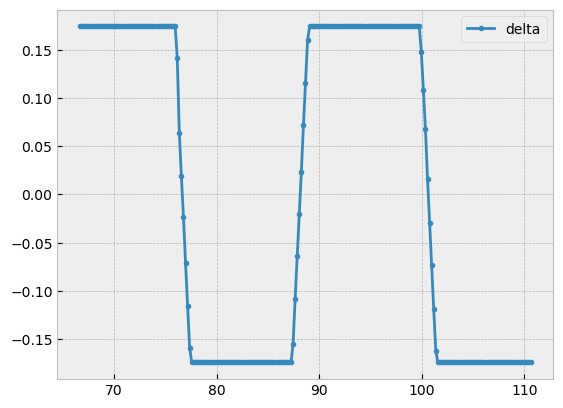

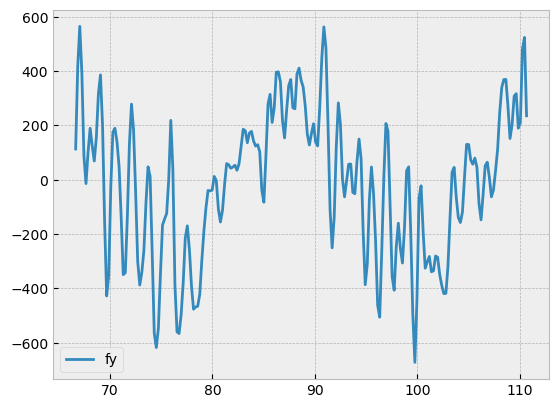

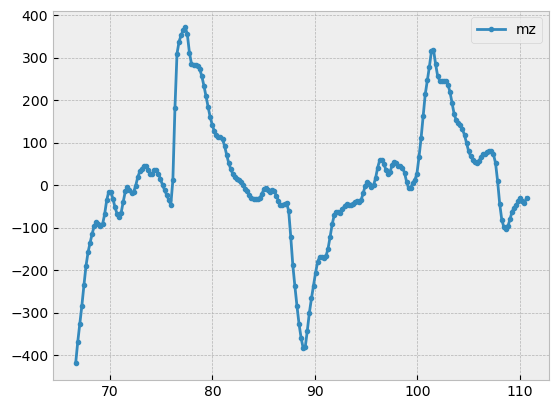

In [48]:
df_.plot(y='delta', style='.-')
df_.plot(y='fy', style='-')
df_.plot(y='mz', style='.-')

In [49]:
df_['mz'].mean()

12.047097724862091

In [50]:
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm)

In [51]:
derivatives

,regressed,$P_{value}$,$conf_{lower}$,$conf_{higher}$
Ndelta,-0.001781,3.241257e-169,-0.001846,-0.001716
Nr,-0.001162,3.199191e-46,-0.001299,-0.001025
Nrrr,0.002055,7.918931e-07,0.001251,0.002858
Nv,0.000355,1.172051e-02,0.000080,0.000631
Nvvv,-0.005651,1.013039e-01,-0.012416,0.001114
Xdeltadelta,0.005211,7.466025e-03,0.001402,0.009019
Xu,-0.000028,6.300427e-01,-0.000141,0.000086
Xvr,-0.001384,2.170063e-01,-0.003586,0.000817
Ydelta,0.010017,8.731518e-18,0.007848,0.012186
Yr,0.008224,2.010492e-05,0.004483,0.011964


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.121
Model:                            OLS   Adj. R-squared (uncentered):              0.113
Method:                 Least Squares   F-statistic:                              15.68
Date:                Mon, 08 May 2023   Prob (F-statistic):                    1.40e-09
Time:                        10:39:49   Log-Likelihood:                          2214.3
No. Observations:                 346   AIC:                                     -4423.
Df Residuals:                     343   BIC:                                     -4411.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xu          -2.785e-05   5.78e-05     -0.482      0.630      -0.000    8.58e-05
Xdeltadelta     0.0052      0.002      2.691      0.007       0.001       0.009
Xvr            -0.0014      0.001     -1.237      0.217      -0.004       0.001
==============================================================================
Omnibus:                       31.328   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.718
Skew:                          -0.572   Prob(JB):                     5.88e-12
Kurtosis:                       4.509   Cond. No.                         88.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.522
Method:                 Least Squares   F-statistic:                              76.71
Date:                Mon, 08 May 2023   Prob (F-statistic):                    1.02e-53
Time:                        10:39:49   Log-Likelihood:                          1716.3
No. Observations:                 346   AIC:                                     -3423.
Df Residuals:                     341   BIC:                                     -3403.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0100      0.001      9.083      0.000       0.008       0.012
Yr             0.0082      0.002      4.324      0.000       0.004       0.012
Yv            -0.0026      0.005     -0.566      0.572      -0.011       0.006
Yvvv          -0.1600      0.112     -1.423      0.156      -0.381       0.061
Yvr           -0.0052      0.005     -1.124      0.262      -0.014       0.004
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   0.629
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                6.446
Skew:                          -0.164   Prob(JB):                       0.0398
Kurtosis:                       3.583   Cond. No.                         351.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              1013.
Date:                Mon, 08 May 2023   Prob (F-statistic):                   3.54e-202
Time:                        10:39:49   Log-Likelihood:                          2918.5
No. Observations:                 346   AIC:                                     -5827.
Df Residuals:                     341   BIC:                                     -5808.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0018    3.3e-05    -54.019      0.000      -0.002      -0.002
Nr            -0.0012   6.95e-05    -16.712      0.000      -0.001      -0.001
Nv             0.0004      0.000      2.534      0.012    7.95e-05       0.001
Nrrr           0.0021      0.000      5.031      0.000       0.001       0.003
Nvvv          -0.0057      0.003     -1.643      0.101      -0.012       0.001
==============================================================================
Omnibus:                       47.887   Durbin-Watson:                   0.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.499
Skew:                          -0.779   Prob(JB):                     6.06e-20
Kurtosis:                       4.926   Cond. No.                         348.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

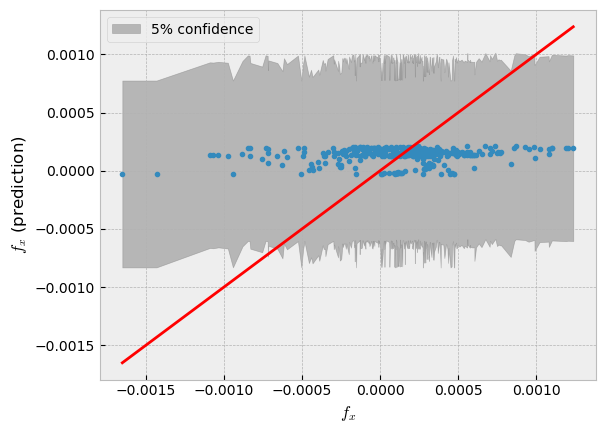

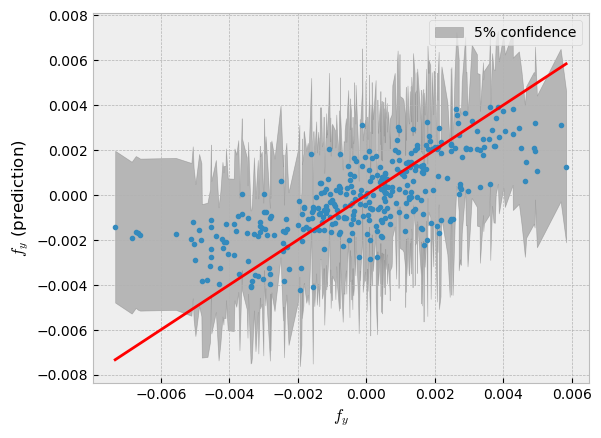

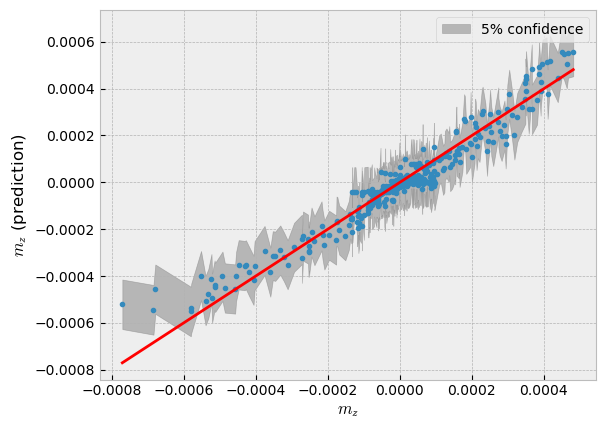

In [52]:
regression.show()

In [53]:
model = create_model_from_motion_regression(regression=regression)

In [54]:
#model.simulate(data_ek_smooth)

In [55]:
data_ = data_ek_smooth.copy()
#data_ = data_.rolling(window=10).mean().dropna()
data_['psi']+=np.deg2rad(1)
data_['delta']-=np.deg2rad(0.8)
data_simulated = simulate_euler(data=data_, model=model, ek=ek)

In [56]:
model_guess = model.copy()
model_guess.parameters = {key:parameters.get(key,0) for key in model.parameters.keys()}
data_simulated_guess = simulate_euler(data=data_ek_smooth, model=model_guess, ek=ek)

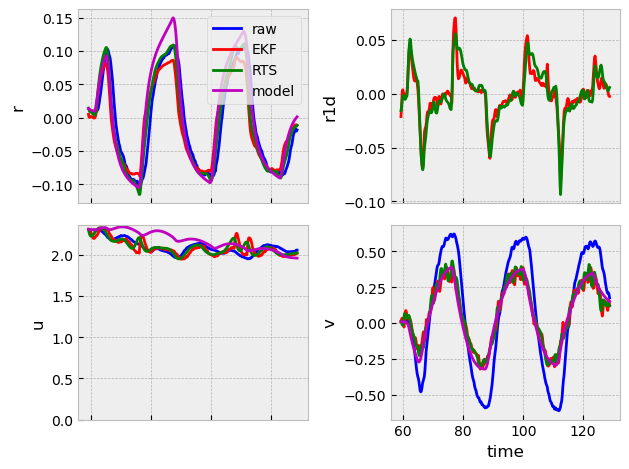

In [57]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
'model':data_simulated,
}
plot(dataframes=dataframes, keys=['u','v','r','r1d']);

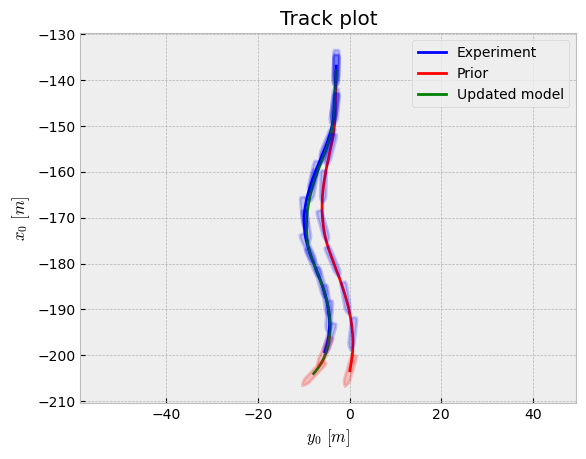

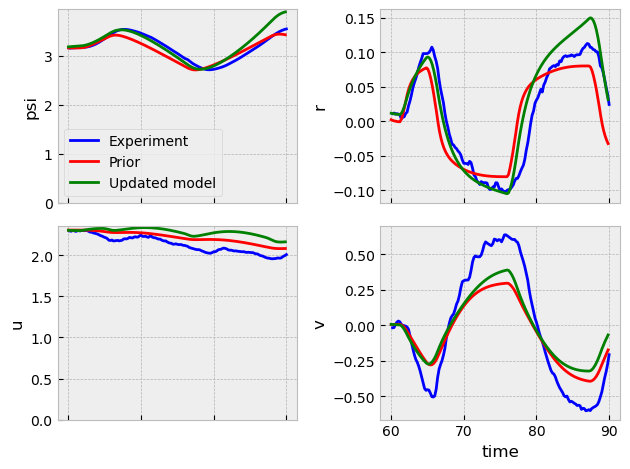

In [58]:

dataframes = {
'Experiment':data.rolling(5).mean(),
'Prior':data_simulated_guess,
'Updated model':data_simulated,
}
time_window=[60,90]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window);
ax.get_figure().savefig("update.svg")
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);

In [59]:
exclude_parameters

In [60]:
itterations = []
derivatives = parameters.copy()
covariance_matrixes_itterations = covariance_matrixes.copy()
exclude_parameters={}

data_ = data_ek_smooth.copy()
#data_ = data_.rolling(window=10).mean().dropna()
data_['psi']+=np.deg2rad(1)
#data_['delta']-=np.deg2rad(0.8)

for i in range(0,5):
    
    ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes_itterations, x0=x0, hydrodynamic_derivatives=derivatives)
    ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes_itterations, hydrodynamic_derivatives=derivatives)
    data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
    regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)
    model = create_model_from_motion_regression(regression=regression)
    data_simulated = simulate_euler(data=data_, model=model, ek=ek_smooth)
    
    covariance_matrixes_itterations['Qd'] = np.array(covariance_matrixes_itterations['Qd'])*0.7
    
    itterations.append(
        {
            'data_ek':data_ek,
            'data_ek_smooth':data_ek_smooth,
            'derivatives':derivatives,
            'data_simulated':data_simulated,
        }
    )

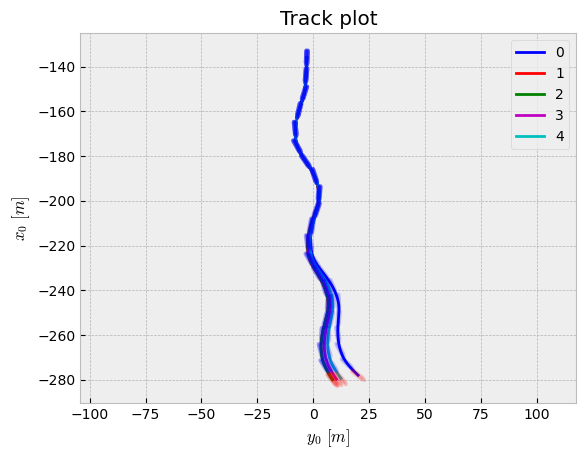

In [61]:
track_plots(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, lpp=ship_data['L'], beam=ship_data['B']);

In [62]:
df_MSE = pd.DataFrame()
for dof in ['u','v','r']:
    df_MSE[dof] = pd.Series({i:mean_squared_error(y_true = data[dof], y_pred=itteration['data_simulated'][dof]) for i,itteration in enumerate(itterations)}, name=dof)

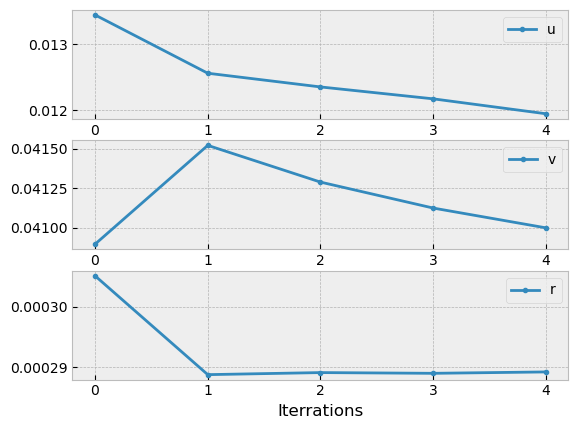

In [63]:
fig,axess =plt.subplots(nrows=3)
for ax,dof in zip(axess,['u','v','r']):
    df_MSE.plot(y=dof, style='.-', ax=ax)
    ax.set_xticks(df_MSE.index)
ax.set_xlabel('Iterrations');


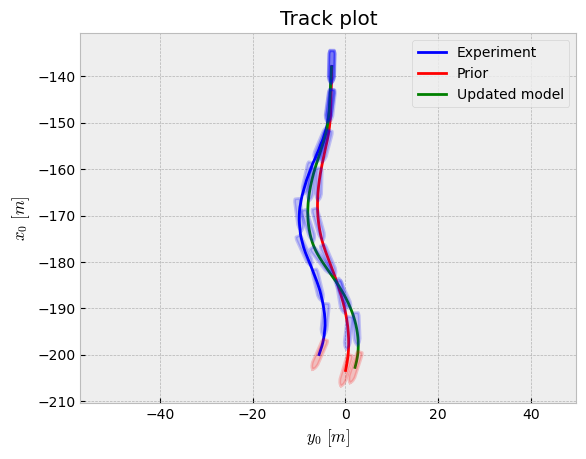

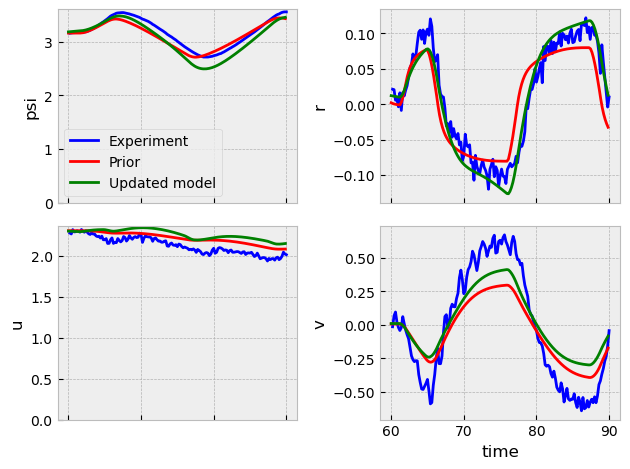

In [64]:
dataframes = {
'Experiment':data.rolling(1).mean(),
'Prior':data_simulated_guess,
'Updated model':itterations[4]['data_simulated'],
}
time_window=[60,90]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window);
#ax.get_figure().savefig("update.svg")
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);